In [3]:
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eye.npy'
!wget 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/face.npy'

--2022-12-06 01:43:30--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.181.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893376 (103M) [application/octet-stream]
Saving to: ‘star.npy’

star.npy            100%[===================>] 102.89M   166MB/s    in 0.6s    

2022-12-06 01:43:31 (166 MB/s) - ‘star.npy’ saved [107893376/107893376]

--2022-12-06 01:43:31--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.181.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176997488 (169M) [application/octet-stream]
S

In [ ]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

NameError: ignored

In [5]:
!mkdir data2

In [6]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  root= 'data1'
  classes = ['star', 'eyeglasses', 'clock', 'eye', 'face']
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data2/'+c+'.npy')
     

In [7]:
download() 


https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eye.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/face.npy


In [8]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

In [9]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [12]:
x_train, y_train, x_test, y_test, class_names = load_data('data2')
num_classes = len(class_names)
image_size = 28

In [13]:
print(len(x_train))


16000


eyeglasses


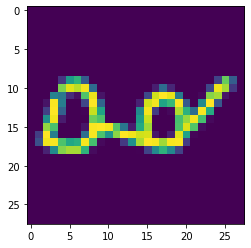

In [14]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [15]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
     

In [18]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(5, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 64)        

In [19]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)


Epoch 1/5
57/57 - 11s - loss: 0.7000 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4062 - val_top_k_categorical_accuracy: 1.0000 - 11s/epoch - 199ms/step
Epoch 2/5
57/57 - 10s - loss: 0.3529 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3163 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 178ms/step
Epoch 3/5
57/57 - 10s - loss: 0.2779 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2574 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 182ms/step
Epoch 4/5
57/57 - 10s - loss: 0.2346 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2471 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 180ms/step
Epoch 5/5
57/57 - 10s - loss: 0.2046 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2323 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 179ms/step


In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


1/1 [==============================] - 0s 48ms/step
['clock']


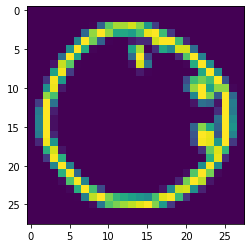

In [26]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:1]
latex = [class_names[x] for x in ind]
print(latex)

In [23]:

with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [24]:
!pip install tensorflowjs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.0 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 16.2 MB 38.5 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
     |████████████████████████████████| 189 kB 49.5 MB/s 
     |████████████████████████████████| 237 kB 66.6 MB/s 
     |████████████████████████████████| 154 kB 66.7 MB/s 
     |████████████████████████████████| 8.3 MB 44.2 MB/s 
     |████████████████████████████████| 51 kB 7.0 MB/s 
     |████████████████████████████████| 439 kB 57.5 MB/s 
     |████████████████████████████████| 1.7 MB 53.8 MB/s 
     |████████████████████████████████| 6.0 MB 48.7 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
    

In [25]:
model.save('keras.h5')